<a href="https://colab.research.google.com/github/Kimbaeda/youngwoo/blob/main/4%EC%9D%BC%EC%B0%A8_%EC%88%99%EC%A0%9C(%EC%8B%A4%EC%A0%9C_%EB%89%B4%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A1%9C_%EB%89%B4%EC%8A%A4%EA%B8%B0%EC%82%AC_%EC%A3%BC%EC%A0%9C%EB%A5%BC_%EB%B6%84%EB%A5%98%ED%95%98%EB%8A%94_%ED%85%8D%EC%8A%A4%ED%8A%B8_%EB%B6%84%EB%A5%98%EA%B8%B0_%EB%A7%8C%EB%93%A4%EA%B8%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 실제 뉴스 데이터로 뉴스기사 주제를 분류하는 텍스트 분류기 만들기

- 기본적인 구조 : 데이터 입력 -> 정제 -> 토큰화 -> 인코딩(TF-IDF)텍스트간의 유사도 -> 모델 -> 예측

## 데이터 수집 및 전처리

크롤링은 한시간 정도 걸림.
크롤링한 데이터 csv로 저장 후 불러옴.

[데이터 다운 링크](https://drive.google.com/file/d/1NieEXeSqTXKtY2oQAi_WMZVwcnL9M6CG/view?usp=sharing)

In [ ]:
import pandas as pd

# 저장한 csv파일 불러오기
csv_path = '/content/news_data.csv'
df = pd.read_table(csv_path, sep=',')
df.head()

,news,code
0,파주시청. 사진제공=파주시 파주시청. 사진제공=파주시\n\n[파주=파이낸셜뉴스 강근...,사회
1,동영상 뉴스\n\n이천 물류창고 화재 발화지점으로 지목된 지하 2층에서 산소절단기의...,사회
2,황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검. 사진...,사회
3,귀갓길 여성을 쫓아가 성범죄를 시도한 20대 남성이 구속됐습니다.서울 강남경찰서는 ...,사회
4,(서울=연합뉴스) 대한약사회가 6일부터 코로나바이러스 감염증 대응 체계를 '사회적 ...,사회


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5249 entries, 0 to 5248
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    5249 non-null   object
 1   code    5249 non-null   object
dtypes: object(2)
memory usage: 82.1+ KB


In [ ]:
df.head()

,news,code
0,파주시청. 사진제공=파주시 파주시청. 사진제공=파주시\n\n[파주=파이낸셜뉴스 강근...,사회
1,동영상 뉴스\n\n이천 물류창고 화재 발화지점으로 지목된 지하 2층에서 산소절단기의...,사회
2,황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검. 사진...,사회
3,귀갓길 여성을 쫓아가 성범죄를 시도한 20대 남성이 구속됐습니다.서울 강남경찰서는 ...,사회
4,(서울=연합뉴스) 대한약사회가 6일부터 코로나바이러스 감염증 대응 체계를 '사회적 ...,사회


In [ ]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부제거
df['news_clean'] = df['news'].str.replace("[^ㄱ-하-ㅣ가-힣]"," ") # 한글이 아니면 전부 제거

In [ ]:
df['news_clean'].head()

0    파주시청  사진제공 파주시 파주시청  사진제공 파주시   파주 파이낸셜뉴스 강근주 ...
1    동영상 뉴스  이천 물류창고 화재 발화지점으로 지목된 지하  층에서 산소절단기의 산...
2    황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검  사진...
3    귀갓길 여성을 쫓아가 성범죄를 시도한   대 남성이 구속됐습니다 서울 강남경찰서는 ...
4     서울 연합뉴스  대한약사회가  일부터 코로나바이러스 감염증 대응 체계를  사회적 ...
Name: news_clean, dtype: object

In [ ]:
# 데이터에 Null값이 없는지 확인
df.isna().sum()

news          0
code          0
news_clean    0
dtype: int64

In [ ]:
len(df)
len(df['news_clean'])

5249

In [ ]:
df.describe(include='all')

,news,code,news_clean
count,5249,5249,5249
unique,3987,3,3985
top,기사 섹션 분류 안내\n\n기사의 섹션 정보는 해당 언론사의 분류를 따르고 있습니다...,사회,기사 섹션 분류 안내 기사의 섹션 정보는 해당 언론사의 분류를 따르고 있습니다 ...
freq,356,2000,356


In [ ]:
df['code'].unique()

array(['사회', '생활/문화', 'IT/과학'], dtype=object)

In [ ]:
df[['news_clean']].nunique()

news_clean    3985
dtype: int64

In [ ]:
df[['news']].nunique()

news    3987
dtype: int64

In [ ]:
# 중복이 있는지 확인
df[['news_clean']].nunique(dropna = False)

news_clean    3985
dtype: int64

In [ ]:
# 중복된 샘플들을 제거하세요.
df.drop_duplicates(subset=['news_clean'], inplace=True)
print('뉴스 기사의 갯수: ',len(df))

뉴스 기사의 갯수:  3985


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3985 entries, 0 to 4954
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   news        3985 non-null   object
 1   code        3985 non-null   object
 2   news_clean  3985 non-null   object
dtypes: object(3)
memory usage: 124.5+ KB


## 데이터 탐색

[구글 코랩(colab) 한글 깨짐 현상 해결방법](https://teddylee777.github.io/colab/colab-korean)

In [ ]:
'''
# 구글 코랩(colab) 한글 깨짐 현상 해결방법
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
'''
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

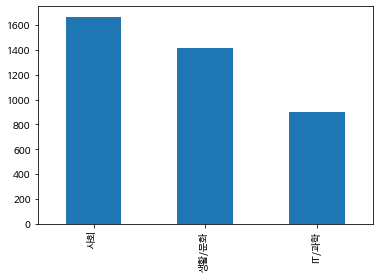

In [ ]:
df['code'].value_counts().plot(kind='bar')

In [ ]:
print(df.groupby('code').size().reset_index(name='count'))

    code  count
0  IT/과학    903
1     사회   1668
2  생활/문화   1414


## 토큰화 Mecab()사용

In [ ]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.


In [ ]:
ls

Mecab-ko-for-Google-Colab/  news_data.csv  sample_data/


In [ ]:
cd Mecab-ko-for-Google-Colab/

/content/Mecab-ko-for-Google-Colab


In [ ]:
ls

images/                                    LICENSE
install_mecab-ko_on_colab190912.sh         README.md
install_mecab-ko_on_colab_light_210108.sh


In [ ]:
! bash install_mecab-ko_on_colab190912.sh

Installing konlpy.....
     |████████████████████████████████| 19.4MB 1.4MB/s 
     |████████████████████████████████| 92kB 10.5MB/s 
     |████████████████████████████████| 450kB 39.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-06-15 09:24:46--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::6b17:d1f5, 2406:da00:ff00::22c2:513, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=mFy9TkJsLRXT%2FjE92Ait7xGue24%3D&Expires=1623750179&AWSAccessKeyId=AKIA6KOSE3B

In [ ]:
# Mecab()이 정상작동하는지 테스트
from konlpy.tag import Mecab
tokenizer = Mecab()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

print(tokenizer.morphs(kor_text)) # morphs() 형태소 분석

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '한', '대', '남성', '이', '구속', '됐', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '해', '수사', '하', '고', '있', '다고', '일', '밝혔', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '폭행', '을', '시도', '하', '려다가', '도망간', '혐의', '를', '받', '는다', '피해', '여성', '이', '저항', '하', '자', '놀란', '씨', '는', '도망갔으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포', '됐', '다', '피해', '여성', '은', '이', '과정', '에서', '경미', '한', '부상', '을', '입', '은', '것', '으로', '전해졌', '다']


## 불용어(stopwords)제거

In [ ]:
# 불용어 (stopwords)
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

In [ ]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data =[]
    # 토큰화
    temp_data = tokenizer.morphs(sentence)
    #불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords]
    text_data.append(temp_data)
  text_data = list(map(' '.join, text_data))
  return text_data

In [ ]:
text_data = preprocessing(df['news_clean'])

In [ ]:
print(text_data[0])

파주 시청 사진 제공 파주시 파주 시청 사진 제공 파주시 파주 강근주 파 주 시 일 관내 취약 계층 만 가구 대해 정부 긴급 재난 지원금 입금 완료 파주 시민 받 긴급 재난 지원금 인 이상 가구 기준 으로 만 원 받 게 되 며 인 가구 만 원 인 가구 만 원 인 가구 만 원 정부 발표 긴급 재난 지원금 파주 시민 지급 금액 다른 이유 국비 - 지방비 부담 비율 파 주 시 이미 모든 시민 경기도 - 파주시 재난 기본소득 인 당 각 만 원 지급 고 어 시민 국비 지원금 만 지급 며 인 가구 기준 으로 총 지원 금액 파주시 재난 기본소득 만 원 경기도 재난 기본소득 만 원 정부 긴급 재난 지원금 만 원 총 만 원 받 게 된다 취약 계층 아닌 시민 오 월 일 부터 소지 고 신용 체크카드 사 홈페이지 에서 긴급 재난 지원금 지원 신청 세대주 가족 지원금 일괄 신청 해야 한다 한편 파 주 시 일 김정기 부시장 단장 으로 긴급 재난 지원금 추진 태 스 크 포스 를 구성 해 긴급 재난 지원금 원활 게 지급 될 도록 지원 한다 권 자 - 재 배포


## 텍스트 유사도

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(text_data, df['code'], random_state=0)

In [ ]:
print('훈련용 뉴스 기사의 갯수 :', len(x_train))
print('테스트용 뉴스 기사의 갯수 :', len(x_test))
print('훈련용 레이블의 갯수 : ', len(y_train))
print('테스트용 레이블의 갯수 : ', len(y_test))

훈련용 뉴스 기사의 갯수 : 2988
테스트용 뉴스 기사의 갯수 : 997
훈련용 레이블의 갯수 :  2988
테스트용 레이블의 갯수 :  997


## 인코딩(텍스트간의 유사도)
- TF-IDF

In [ ]:
# dtm
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(x_train)
# fit_transform : 학습할 때와 동일한 기반 설정으로 동일하게 테스트 데이터를 변환해야 하는 것

# tfidf
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

In [ ]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

# 숙제 모델변경해보기

- 로지스틱 회귀가 accuracy 0.87로 가장 높았다.
1. 로지스틱 회귀(LogisticRegression)
2. 결정 트리 (DecisionTreeclassifier)
3. 랜덤 포레스트 (randomforestClassifier)
4. 그래디언트 부스팅 트리(gradientBoostingClassifier)

## 모델(머신러닝-나이브 베이즈 분류기)

- accuracy 0.83

In [ ]:
# x train TF-IDF벡터, y train 레이블
# 나이브 베이즈 분류기를 수행
clf = MultinomialNB().fit(x_train_tfidf, y_train)

### 평가

In [ ]:
y_pred = clf.predict(tfidf_vectorizer(x_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.91      0.78      0.84       227
          사회       0.78      0.91      0.84       437
       생활/문화       0.85      0.75      0.79       333

    accuracy                           0.83       997
   macro avg       0.85      0.81      0.83       997
weighted avg       0.83      0.83      0.83       997



## 모델 로지스틱 회귀 (Logistic Regression)

- accuracy 0.87

In [ ]:
from sklearn.linear_model import LogisticRegression #logistic regression

model = LogisticRegression()
model.fit(x_train_tfidf, y_train)
y_pred_lr=model.predict(tfidf_vectorizer(x_test))
print(metrics.classification_report(y_pred_lr, y_test))

              precision    recall  f1-score   support

       IT/과학       0.86      0.91      0.88       215
          사회       0.89      0.86      0.88       451
       생활/문화       0.84      0.85      0.85       331

    accuracy                           0.87       997
   macro avg       0.87      0.87      0.87       997
weighted avg       0.87      0.87      0.87       997



## 모델 결정트리 (Decision Tree)

- accuracy 0.72

In [ ]:
from sklearn.tree import DecisionTreeClassifier #Decision Tree

model=DecisionTreeClassifier()
model.fit(x_train_tfidf, y_train)
y_pred_dt=model.predict(tfidf_vectorizer(x_test))
print(metrics.classification_report(y_pred_dt, y_test))

              precision    recall  f1-score   support

       IT/과학       0.68      0.73      0.70       213
          사회       0.73      0.76      0.75       423
       생활/문화       0.72      0.66      0.69       361

    accuracy                           0.72       997
   macro avg       0.71      0.72      0.71       997
weighted avg       0.72      0.72      0.72       997



## 모델 랜덤 포레스트 (randomforestClassifier)
- accuracy 0.84

n_estimatos: 결정 트리의 개수를 의미합니다. 디폴트값은 10개입니다. 계속 증가시킨다고 해서 성능이 무조건 향상되는 것은 아닙니다.(개수의 수가 늘어날수록 수행 시간이 오래 걸린다는 것을 감안하여야 합니다.)

max_features: 결정 트리의 max_features 파라미터와 동일합니다. 랜덤 포레스트에서는 디폴트 값이 'auto'입니다.  auto: sqrt(전체 피처 개수)
결정 트리와 동일하게 과적합 개선을 위해서 max_depth와 min_samples_leaf가 사용이 됩니다.
 
[참조](https://jaaamj.tistory.com/35)

In [ ]:
from sklearn.ensemble import RandomForestClassifier #Random Forest

model=RandomForestClassifier(n_estimators=100)
model.fit(x_train_tfidf, y_train)
y_pred_rf=model.predict(tfidf_vectorizer(x_test))
print(metrics.classification_report(y_pred_rf, y_test))

              precision    recall  f1-score   support

       IT/과학       0.86      0.85      0.85       230
          사회       0.89      0.82      0.86       472
       생활/문화       0.75      0.85      0.80       295

    accuracy                           0.84       997
   macro avg       0.83      0.84      0.84       997
weighted avg       0.84      0.84      0.84       997



## 모델 그래디언트 부스팅 트리(gradientBoostingClassifier)

- accuracy 0.84

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model=GradientBoostingClassifier()
model.fit(x_train_tfidf, y_train)
y_pred_gbrt=model.predict(tfidf_vectorizer(x_test))
print(metrics.classification_report(y_pred_gbrt, y_test))


              precision    recall  f1-score   support

       IT/과학       0.85      0.88      0.87       221
          사회       0.86      0.87      0.87       433
       생활/문화       0.83      0.80      0.82       343

    accuracy                           0.85       997
   macro avg       0.85      0.85      0.85       997
weighted avg       0.85      0.85      0.85       997



## 모델 서포트 벡터 머신(SVM) radial basis function (RBF) 커널을 사용
- Radial Support Vector Machines(rbf-SVM)
- accuracy 0.84


In [ ]:
from sklearn import svm #support vector Machine

model=svm.SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(x_train_tfidf, y_train)
y_pred_rbf_svm=model.predict(tfidf_vectorizer(x_test))
print(metrics.classification_report(y_pred_rbf_svm, y_test))

              precision    recall  f1-score   support

       IT/과학       0.77      0.92      0.84       189
          사회       0.89      0.85      0.87       455
       생활/문화       0.83      0.78      0.81       353

    accuracy                           0.84       997
   macro avg       0.83      0.85      0.84       997
weighted avg       0.85      0.84      0.84       997



## 모델 선형 서포트 벡터 머신
- Linear Support Vector Machines(linear-SVM)
- accuracy 0.81

In [ ]:
from sklearn import svm #support vector Machine

model=svm.SVC(kernel='linear',C=0.1,gamma=0.1)
model.fit(x_train_tfidf, y_train)
y_pred_linear_svm=model.predict(tfidf_vectorizer(x_test))
print(metrics.classification_report(y_pred_linear_svm, y_test))

              precision    recall  f1-score   support

       IT/과학       0.65      0.93      0.76       158
          사회       0.89      0.82      0.86       476
       생활/문화       0.81      0.74      0.77       363

    accuracy                           0.81       997
   macro avg       0.78      0.83      0.80       997
weighted avg       0.82      0.81      0.81       997



## 모델 K-최근접이웃(KNN)
- K-Nearest Neighbours(KNN)
- accuracy 0.83

In [ ]:
from sklearn.neighbors import KNeighborsClassifier #KNN

model=KNeighborsClassifier() 
model.fit(x_train_tfidf, y_train)
y_pred_knn=model.predict(tfidf_vectorizer(x_test))
print(metrics.classification_report(y_pred_knn, y_test))

              precision    recall  f1-score   support

       IT/과학       0.93      0.80      0.86       262
          사회       0.84      0.83      0.84       441
       생활/문화       0.75      0.85      0.80       294

    accuracy                           0.83       997
   macro avg       0.84      0.83      0.83       997
weighted avg       0.84      0.83      0.83       997



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


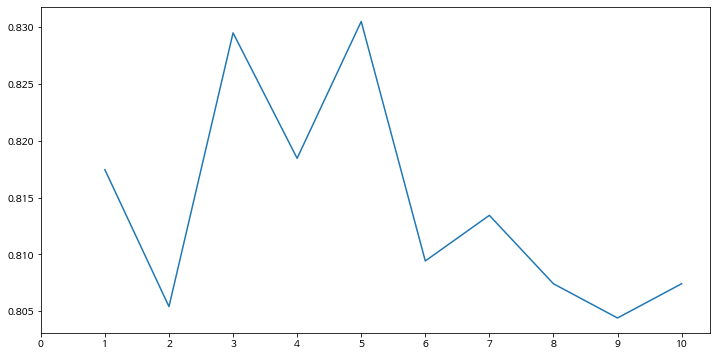

n값에 대한 정확도(accuracy): [0.81745236 0.80541625 0.82948847 0.81845537 0.83049147 0.80942828
 0.81344032 0.80742227 0.80441324 0.80742227] 최대값 0.8304914744232698


In [ ]:
a_index=list(range(1,11))
a=pd.Series()
x=[0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    model=KNeighborsClassifier(n_neighbors=i) 
    model.fit(x_train_tfidf, y_train)
    y_pred_knn=model.predict(tfidf_vectorizer(x_test))
    a=a.append(pd.Series(metrics.accuracy_score(y_pred_knn, y_test)))
plt.plot(a_index, a)
plt.xticks(x)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()
print('n값에 대한 정확도(accuracy):',a.values,'최대값',a.values.max())

n값이 5일때 제일 정확도가 높으므로 n값을 따로 다시 지정해줄 필요는 없다.(n_neighbors default 값이 5이다.)

## 모델 다층 퍼셉트론
- accuracy 0.87

In [ ]:
from sklearn.neural_network import MLPClassifier

model=MLPClassifier() 
model.fit(x_train_tfidf, y_train)
y_pred_mlpc=model.predict(tfidf_vectorizer(x_test))
print(metrics.classification_report(y_pred_mlpc, y_test))

              precision    recall  f1-score   support

       IT/과학       0.91      0.86      0.88       239
          사회       0.86      0.88      0.87       426
       생활/문화       0.84      0.85      0.85       332

    accuracy                           0.87       997
   macro avg       0.87      0.86      0.87       997
weighted avg       0.87      0.87      0.87       997



## 사용한 모델 정확도 순위

In [ ]:
accuracys = []
accuracys.append(metrics.accuracy_score(y_pred,y_test))
accuracys.append(metrics.accuracy_score(y_pred_lr,y_test))
accuracys.append(metrics.accuracy_score(y_pred_dt,y_test))
accuracys.append(metrics.accuracy_score(y_pred_rf,y_test))
accuracys.append(metrics.accuracy_score(y_pred_gbrt,y_test))
accuracys.append(metrics.accuracy_score(y_pred_rbf_svm,y_test))
accuracys.append(metrics.accuracy_score(y_pred_linear_svm,y_test))
accuracys.append(metrics.accuracy_score(y_pred_knn,y_test))
accuracys.append(metrics.accuracy_score(y_pred_mlpc,y_test))
accuracy_labels = ['나이브 베이즈','로지스틱 회귀','결정 트리','랜덤포레스트','그래디언트 부스팅 트리','RBF-SVM','linear-SVM','K-최근접이웃','다층 퍼셉트론']

dictionary = dict(zip(accuracy_labels, accuracys))
# print(dictionary)
acc1 = pd.DataFrame([dictionary])

acc1.T.sort_values(0, ascending=False)

,0
로지스틱 회귀,0.868606
다층 퍼셉트론,0.865597
그래디언트 부스팅 트리,0.850552
RBF-SVM,0.841525
랜덤포레스트,0.836510
나이브 베이즈,0.827482
linear-SVM,0.809428
K-최근접이웃,0.807422
결정 트리,0.718154
